# Scikit-Learn Regressor Comparison

### Prerequisites

# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


from datetime import datetime

from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Set random state:

In [2]:
random_state = 13

In [3]:
%load_ext watermark
%watermark --iversions

numpy     : 1.21.5
matplotlib: 3.5.2
scipy     : 1.9.1
pandas    : 1.4.3
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]



# Creating Data

In [4]:
def make_linear(XMIN, XMAX, N, noise=3, random_state=None, w=10, b=3):
    """Make x and y for a 1D linear regression problem."""
    # print('make_linear start')
    def f(x, w, b):
        return w*x + b
    rng = np.random.default_rng(random_state)
    x = np.linspace(XMIN, XMAX, num=N) + rng.normal(0, noise/10, N)
    y = f(x, w, b) + rng.normal(0, noise, N)
    #print('make_linear end')
    return x.reshape(-1, 1), y

def make_noisy(XMIN, XMAX, N, noise=3, random_state=None):
    xa, ya = make_linear(XMIN, XMAX, N=N, noise=noise, random_state=random_state)
    #print('xa size:', np.size(xa))
    #print('ya size:', np.size(ya))
    rng = np.random.default_rng(random_state)
    
    if noise:
        xn = np.random.normal(-1*noise/2.5, 1*noise/2.5, len(range(N)))
        yn = np.random.normal(-1*noise/2.5, 1*noise/2.5, len(range(N)))
        xb = xa.reshape(-1,1) + xn.reshape(-1,1)
        yb = ya + yn
        #print('xb shape w/noise:', np.shape(xb))
        #print('yb shape w/noise:', np.shape(yb))
    else:
        xb, yb = np.array([]), np.array([])
        #print('xb size:', np.size(xb))
        #print('yb size:', np.size(yb))

    return np.vstack([xa, xb.reshape(-1, 1)]), np.hstack([ya, yb])

def make_poly(XMIN, XMAX, N=50, noise=3, random_state=None):
    def f(x):
        return 3*x**2 + 9*x - 10
    rng = np.random.default_rng(random_state)
    x = np.linspace(XMIN+0.25, XMAX-0.25, num=N) + rng.normal(0, noise/10, N)
    y = f(x) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

def make_periodic(XMIN, XMAX, N=50, noise=3, random_state=None):
    def f(x):
        return 10*np.sin(3*x) + 3*np.cos(2*x) + 5*np.sin(2*x)
    rng = np.random.default_rng(42)
    x = np.linspace(XMIN+0.25, XMAX-0.25, num=N) + rng.normal(0, noise/10, N)
    y = f(x) + rng.normal(0, noise, N)
    return x.reshape(-1, 1), y

def create_regression_datasets(XMIN, XMAX, N=50, noise=3, random_state=None):
    print('xmin' , XMIN, 'xmax:', XMAX, 'N:', N)
    funcs = {
        'Linear': make_linear,
        'Noisy': make_noisy,
        'Polynomial': make_poly,
        'Periodic': make_periodic,
    }
    print('create_regression_datasets')
    return {k: f(XMIN, XMAX, N, noise, random_state) for k, f in funcs.items()}

## ML Models to Test

In [5]:
models = {
    '': dict(),
    'Linear': dict(model=Ridge(), pen='alpha', mi=0, ma=10),
    'Polynomial': dict(model=make_pipeline(PolynomialFeatures(2), Ridge()), pen='ridge__alpha', mi=0, ma=10),
    'Huber': dict(model=HuberRegressor(), pen='alpha', mi=0, ma=10),
    'Nearest Neighbours': dict(model=KNeighborsRegressor(), pen='n_neighbors', mi=3, ma=9),
    'Linear SVM': dict(model=SVR(kernel='linear'), pen='C', mi=1e6, ma=1),
    'RBF SVM': dict(model=SVR(kernel='rbf'), pen='C', mi=1e6, ma=1),
    'Gaussian Process': dict(model=GaussianProcessRegressor(random_state=random_state), pen='alpha', mi=1e-12, ma=1),
    'Decision Tree': dict(model=DecisionTreeRegressor(random_state=random_state), pen='max_depth', mi=20, ma=3),
    'Random Forest': dict(model=RandomForestRegressor(random_state=random_state), pen='max_depth', mi=20, ma=4),
    'Neural Net': dict(model=MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, tol=0.01, random_state=random_state), pen='alpha', mi=0, ma=10),    
}

## Make the data:

If you want to re-run the test, start here!

In [6]:
# Number of data points
N = 228 # once you make this above 500, crowds the plot

split_size = 0.4 # Metric to adjust split size

x_min = -5.5
x_max = 15.5

In [7]:
datasets  = create_regression_datasets(XMIN = x_min , XMAX = x_max, N=N, noise=3, random_state=random_state)
noiseless = create_regression_datasets(XMIN = x_min , XMAX = x_max, N=N, noise=0, random_state=0)

xmin -5.5 xmax: 15.5 N: 228
create_regression_datasets
xmin -5.5 xmax: 15.5 N: 228
create_regression_datasets


## Plot (& Model) the data:

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


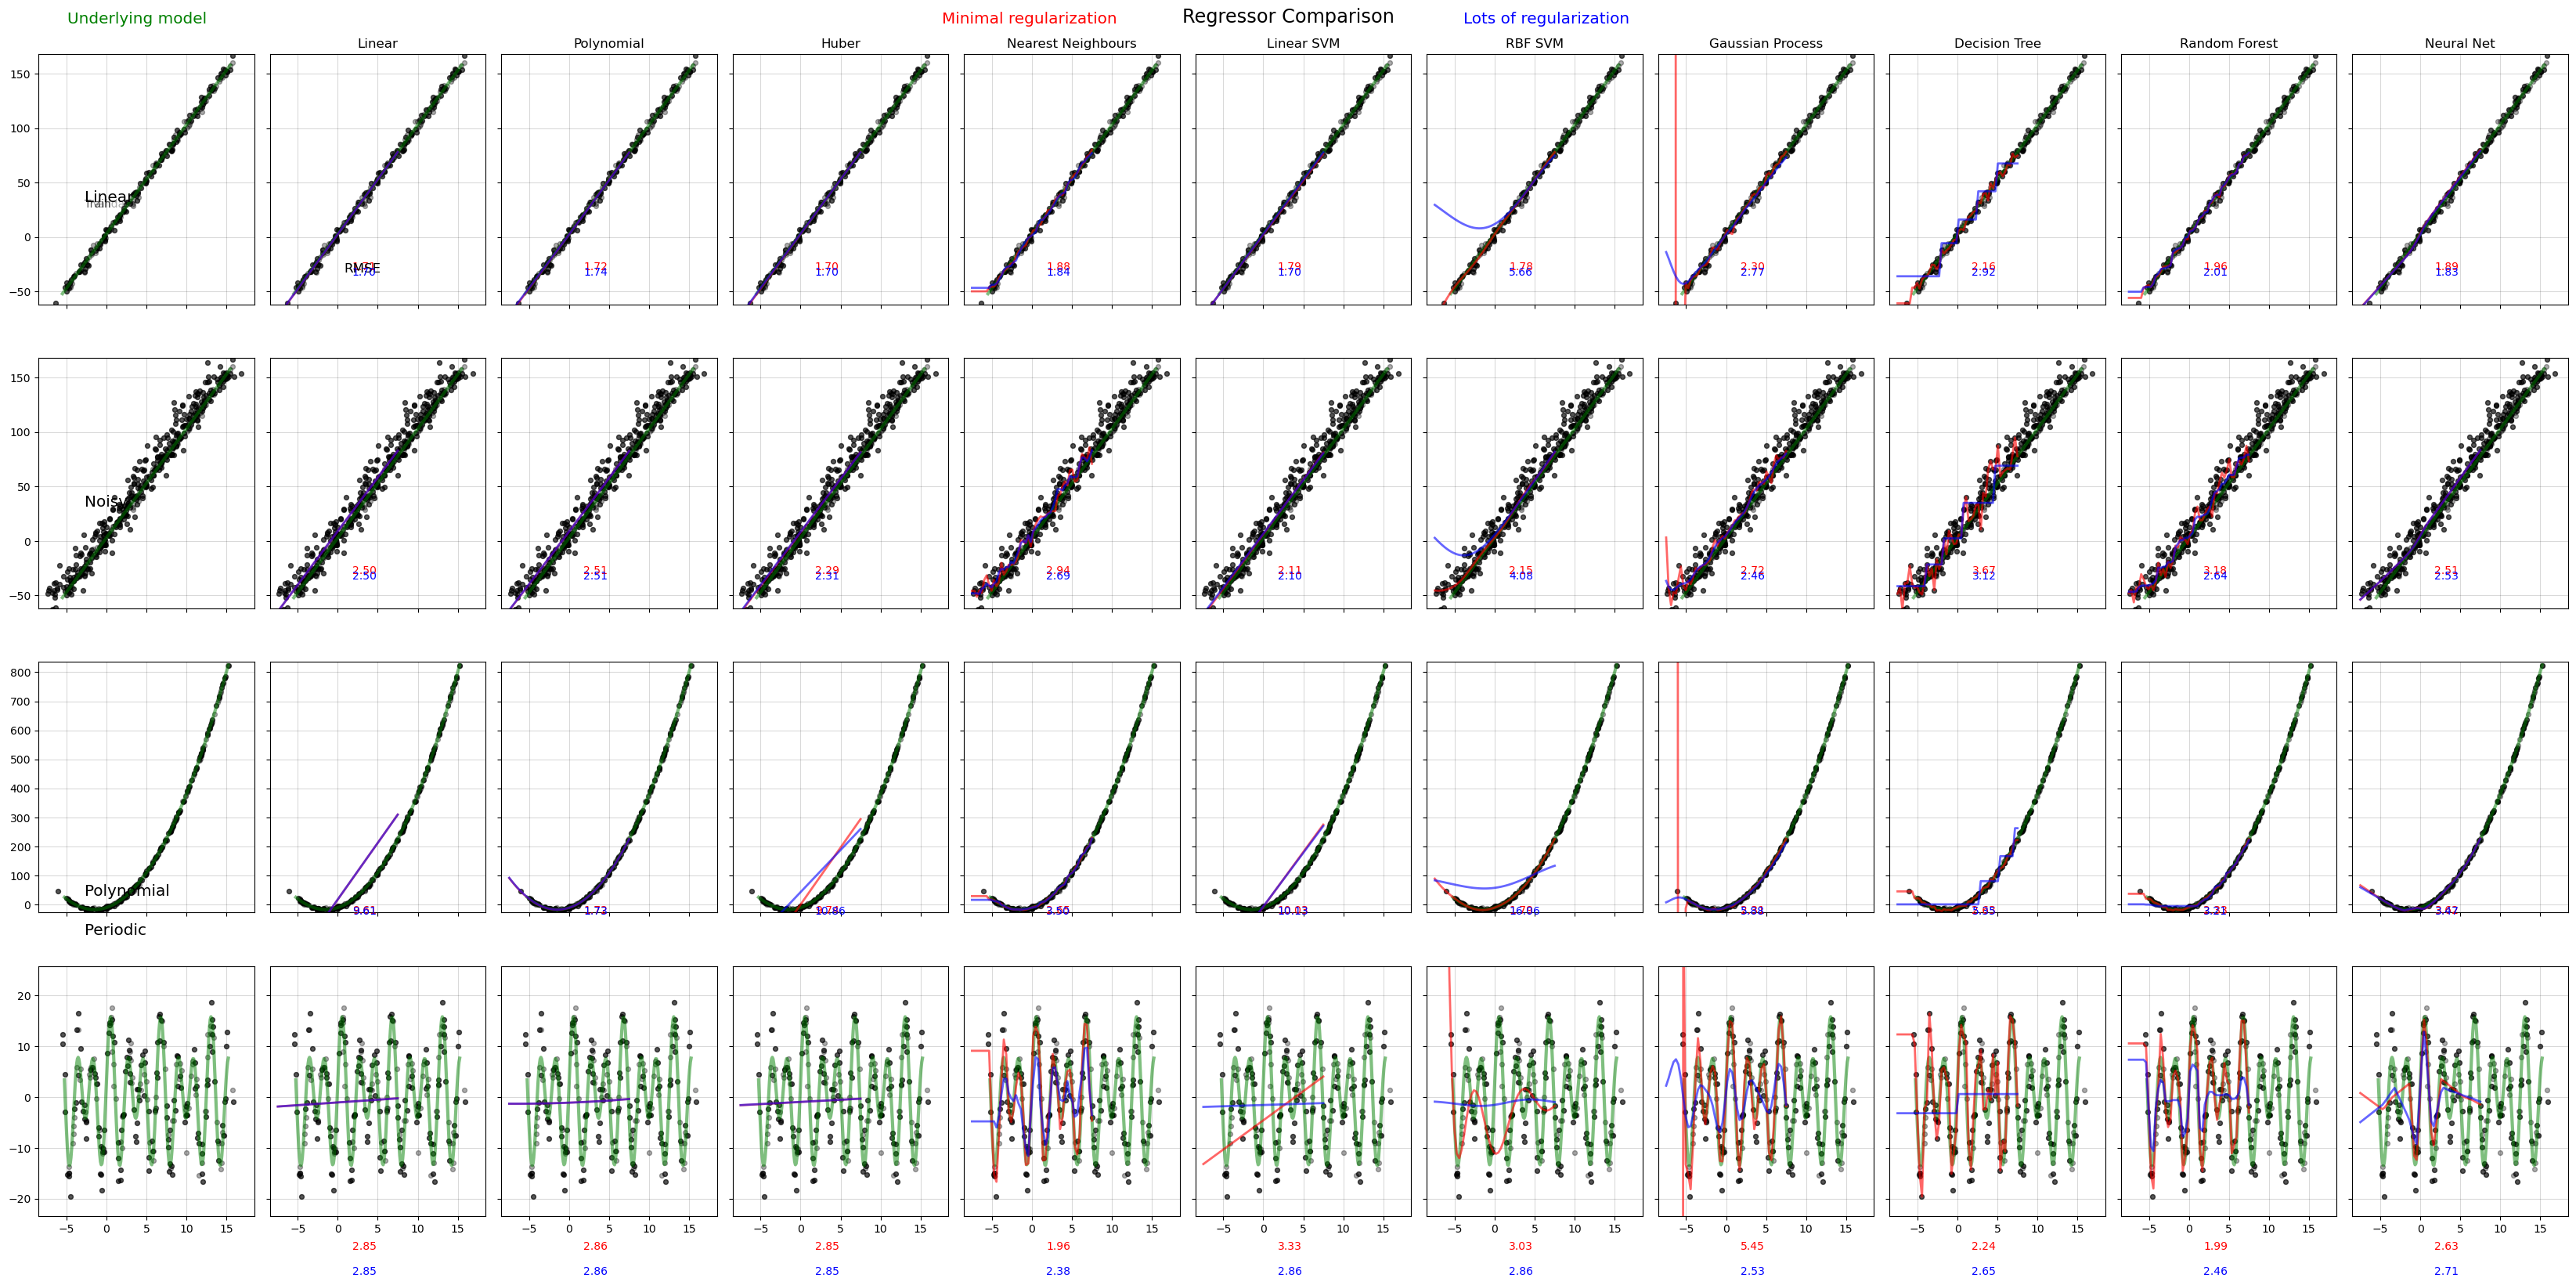

In [8]:
fig, axs = plt.subplots(nrows=len(datasets),
                        ncols=len(models),
                        figsize=(3*len(models), 4*len(datasets)),
                        sharex=True, facecolor='white'
                        )

label_rmse, label_train = True, True

# lists to append within the loop

_models = []
_reg = []
_data_type = []
_time = []
RMSE_score = []
rscore = np.nan
mscore = np.nan

for ax_row, (dataname, (x, y)), (_, (x_, y_)) in zip(axs, datasets.items(), noiseless.items()):

    for ax, (modelname, model) in zip(ax_row, models.items()):
        
        if dataname != 'Noisy':
            x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=split_size, random_state=random_state)
        else:
            x_sig, x_noise = x[:N], x[N:]
            y_sig, y_noise = y[:N], y[N:]
            x_train, x_val, y_train, y_val = train_test_split(x_sig, y_sig, test_size=split_size, random_state=random_state)            
            x_train = np.vstack([x_train, x_noise])
            y_train = np.hstack([y_train, y_noise])
            
        # Plot the noise-free case.
        ax.plot(x_, y_, c='g', alpha=0.5, lw=3)

        # Plot the training and validation data.
        ax.scatter(x_train, y_train, s=18, c='k', alpha=0.67)
        ax.scatter(x_val, y_val, s=18, c='k', alpha=0.33)

        if label_train:
            ax.text(-2.75, 27, f'Train', c='k', alpha=0.67)
            ax.text(-1.75, 27, f'Validate', c='k', alpha=0.33)
            label_train = False

        _models.append(modelname)
        _models.append(modelname)
        _data_type.append(dataname)
        _data_type.append(dataname)
        # Min Regularization Start
        start_time = datetime.now()
        if (m := model.get('model')) is not None:
            
            xm = np.linspace(-7.5, 7.5).reshape(-1, 1)
            if (pen := model.get('pen')) is not None:
                m.set_params(**{pen: model['mi']})  # Min regularization.
            m.fit(x_train, y_train)
            ŷm = m.predict(xm)
            ax.plot(xm, ŷm, 'r', lw=2, alpha=0.6)

            ŷ = m.predict(x_val)
            mscore = np.sqrt(mean_squared_error(y_val, ŷ, squared=False))
            
            ax.text(1.8, -30, f'{mscore:.2f}', c='r')
            
            if label_rmse:
                ax.text(0.75, -32.5, f'RMSE', c='k', fontsize='large')
                label_rmse = False       

        end_time = datetime.now()

        mi_t = end_time - start_time
        # print(modelname, 'Min Reg', 'Duration: {}'.format(mi_t.microseconds))    
        # append metrics
        _reg.append('min')
        RMSE_score.append(np.round(mscore, 3))
        _time.append(mi_t.microseconds)

        # Max Regularization Start
        start_time_ma = datetime.now()
        if (pen := model.get('pen')) is not None:
            m.set_params(**{pen: model['ma']})  # Max regularization.
            r = m.fit(x_train, y_train)
            ŷr = r.predict(xm)
            ax.plot(xm, ŷr, 'b', lw=2, alpha=0.6)

            ŷ = r.predict(x_val)
            rscore = np.sqrt(mean_squared_error(y_val, ŷ, squared=False))
            
            ax.text(1.8, -35, f'{rscore:.2f}', c='b')
        
        end_time_ma = datetime.now()
        ma_t = end_time_ma - start_time_ma
        # print(modelname, 'Max Reg', 'Duration: {}'.format(ma_t.microseconds)) 
        RMSE_score.append(np.round(rscore, 3))
        _reg.append('max')
        _time.append(ma_t.microseconds)

        ax.set_ylim(np.min(y_)-10, np.max(y_)+10)
        ax.set_xlim(x_min -3 , x_max + 3)

        if ax.get_subplotspec().is_first_row():
            ax.set_title(modelname)

        if ax.get_subplotspec().is_first_col():
            ax.text(-2.75, 32, f'{dataname}', c='k', fontsize='x-large')
        else:
            ax.set_yticklabels([])

        ax.grid(c='k', alpha=0.15)

plt.figtext(0.5, 1.0, 'Regressor Comparison', fontsize='xx-large', color='k', ha='center', va='bottom')
plt.figtext(0.0275, 1.0, 'Underlying model', fontsize='x-large', color='g', ha='left', va='bottom')
plt.figtext(0.4, 1.0, 'Minimal regularization', fontsize='x-large', color='red', ha='center', va='bottom')
plt.figtext(0.6, 1.0, 'Lots of regularization', fontsize='x-large', color='blue', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('comparison.png', dpi=90)
plt.show()

# Making a dataframe of the results:

In [9]:
dict = {'data_type': _data_type, 
        'model': _models, 
        'regularization': _reg,
        'RMSE': RMSE_score,
        'time': _time} 
    
df = pd.DataFrame(dict)

df = df[df.model != '']

In [10]:
df

,data_type,model,regularization,RMSE,time
2,Linear,Linear,min,1.708,1996
3,Linear,Linear,max,1.704,1379
4,Linear,Polynomial,min,1.724,4104
5,Linear,Polynomial,max,1.735,1968
6,Linear,Huber,min,1.704,6205
...,...,...,...,...,...
83,Periodic,Decision Tree,max,2.653,1364
84,Periodic,Random Forest,min,1.993,96352
85,Periodic,Random Forest,max,2.460,87735
86,Periodic,Neural Net,min,2.633,311562


In [11]:
classes = ['Linear', 'Polynomial', 'Huber', 'Nearest Neighbours',
       'Linear SVM', 'RBF SVM', 'Gaussian Process', 'Decision Tree',
       'Random Forest', 'Neural Net']


values = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


colors = ListedColormap([
        'red', 
        'green', 
        'blue', 
        'yellow',
        'teal',
        'lime',
        'gold',
        'Maroon',
        'violet',
        'darkgreen'])

R-squared: 0.023955
R-squared: 0.125488
R-squared: 0.006486
R-squared: 0.000334


/var/folders/mv/8ltb3p0j0wv_rnz_fytclgxc0000gq/T/ipykernel_8406/1216583894.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


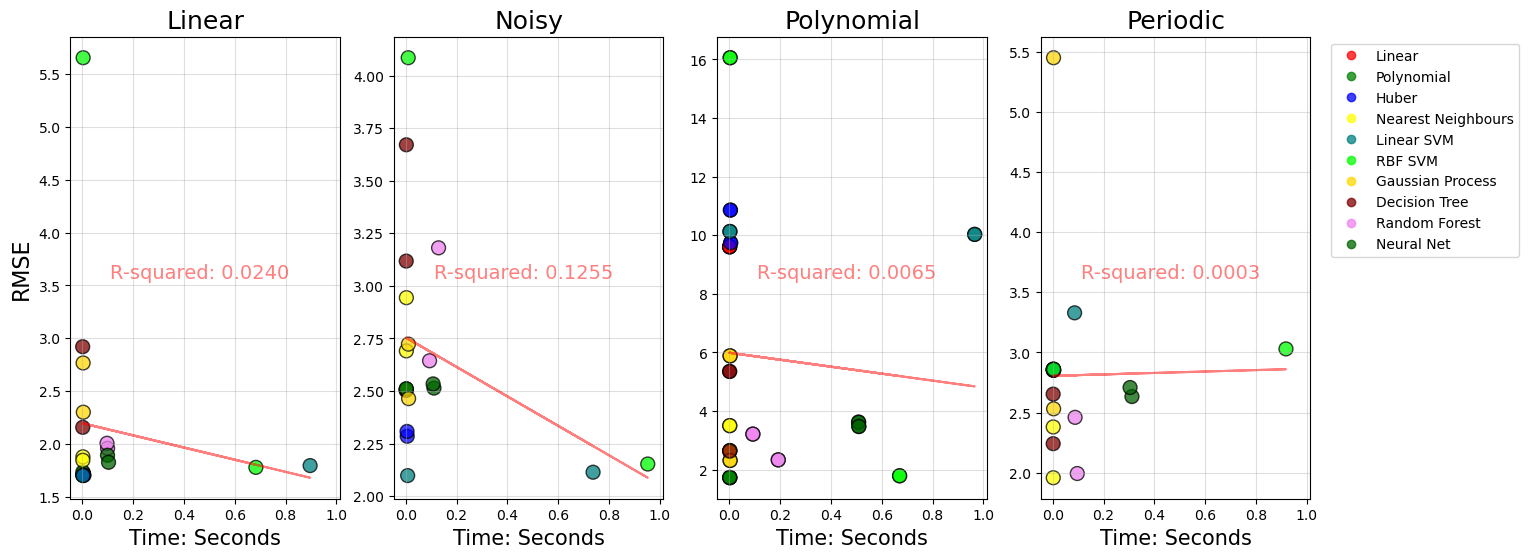

In [13]:
f,axs = plt.subplots(nrows = 1, ncols = 4, sharex=True, sharey=False, figsize=(16,6))

for i in range(len(df.data_type.unique())):
  dat = df.data_type.unique()[i]
  
  x = df[df.data_type == dat].time/1e6 # conversion from microsecond to millisecond
  y = df[df.data_type == dat].RMSE
  
  # Quick Linear Regression
  res = stats.linregress(x, y)
  print(f"R-squared: {res.rvalue**2:.6f}")
  axs[i].plot(x, res.intercept + res.slope*x, 'r', label='fitted line', alpha = 0.5)
  axs[i].annotate(f"R-squared: {res.rvalue**2:.4f}", xy=(40, 220), xycoords='axes pixels', size=14, color = 'r', alpha = 0.5)
  axs[i].grid(True, alpha=0.4)
  
  axs[i].scatter(x, y, c=values, cmap=colors, s = 100, alpha=.75, edgecolors='black')
  axs[0].set_ylabel('RMSE', size=16)
  axs[i].set_xlabel('Time: Seconds', size=15)
  axs[i].set_title(dat, size=18)
  if i == 2:
    axs[i].legend(handles=axs[i].scatter(x, y, c=values, cmap=colors, s = 100, alpha=.75, edgecolors='black').legend_elements()[0], labels=classes, bbox_to_anchor=(3,1))

plt.tight_layout()
plt.savefig('crossplot.png', dpi=150)
plt.show()